# Assignment 3 - Part 2

In this assignment, you are to architect a neural network to perform text classification.

Grading scheme:

- Model: 10
- Training: 10
- Test accuracy: 20

```
    >= 70%: 5/10
    >= 75%: 10/20
    >= 80%: 15/20
    >= 85%: 20/20
```

Total: 40

In [ ]:
"🔒"
import torch
from torch import (nn, optim)
from torch.utils.data import (Dataset, DataLoader, random_split)
from torchsummaryX import summary
import pandas as pd
import numpy as np
import warnings
import test_lib
from importlib import reload
reload(test_lib)
warnings.filterwarnings('ignore')

## Load dataset and vocabulary from file

You are given two dataset files for training and testing.

In [ ]:
"🔒"
train_dataset = torch.load('./train_dataset.npz')
test_dataset = torch.load('./test_dataset.npz')

print("Training dataset: %d" % len(train_dataset))
print("Test dataset: %d" % len(test_dataset))

## Load the vocabulary

You are given the vocabulary file.  This is used **only** for decoding
the integers in the dataset.  It is not used for training, nor testing.

In [ ]:
"🔒"
vocab = torch.load('./vocab.pt')
print("There are %d tokens in vocabulary." % len(vocab))

## Check data

In [ ]:
"🔒"
# @check
# @title: data integrity

x, y = train_dataset[100]
print("Review:", " ".join(vocab.lookup_tokens(x.numpy().tolist())))
print("Label:", y.item())

## Model

Construct a model that can process and learn from the samples from dataset.

**Hints:**  Learn advanced architectural layers:

- LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- Conv1D: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
- MaxPool1d: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
- Dropout: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [548]:
"✍️"
# @workUnit

train_dataset = torch.load('./train_dataset_extended.npz')
test_dataset = torch.load('./test_dataset_extended.npz')


print("Training dataset: %d" % len(train_dataset))
print("Test dataset: %d" % len(test_dataset))

x, y = train_dataset[100]
print("Review:", " ".join(vocab.lookup_tokens(x.numpy().tolist())))
print("Label:", y.item())
print("Sequence Length: %d"% len(x))

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(2000, 32)
        self.conv1d = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.8)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(64, 256, num_layers=2, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fc = nn.Linear(32, 2)
    def forward(self, x):
        out = self.embedding(x)
        out = out.transpose(1, 2)
        out = self.conv1d(out)
        out = self.ReLU(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        out = out.transpose(1, 2)
        y, (s, c) = self.lstm(out)
        out = self.mlp(c[0])
        return self.fc(out)

Training dataset: 20000
Test dataset: 5000
Review: <unk> the life of being <unk> by her father . . and the <unk> <unk> who dies in an <unk> <unk> powers <unk> <unk> who is simply <unk> <unk> her way through the <unk> inside a bank business in big city <unk> . when a <unk> lover murders who was supposed to be his next father in law and <unk> s new lover the sky s the <unk> for <unk> as she has written down her various relationships in a <unk> and <unk> makes it known the <unk> will <unk> it if certain pay doesn t come into her hands . <unk> <unk> <unk> to the bank <unk> <unk> george <unk> <unk> <unk> to paris instead of <unk> over lots of <unk> but soon finds himself <unk> in love after various <unk> with her in the city of love . this makes <unk> s mouth water as now she ll have <unk> the <unk> of success <unk> a man of <unk> and <unk> bring <unk> her way . though <unk> <unk> which will bring her to make a <unk> that <unk> her successful way of <unk> those <unk> . . <unk> now her husba

In [549]:
"🔒"
# @check
# @title: verify model output

model = MyModel()
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
xs, targets = next(iter(dataloader))
model(xs).shape

torch.Size([128, 2])

## Training

Implement a function `train` that will train the model.

Inputs are:

- model: an instance of the `MyModel`
- train_dataset: a dataset to be trained on.
- epochs: the number of epochs
- max_batches: optional integer that will limit the number of batches per epoch.

Returns a Pandas DataFrame will columns: `train_loss` and `train_acc` which are
the training loss and accuracy per epoch.

**Hint:**

- Start with a simple model, and make sure that you can get a decent performance.
- Start with a small number of `max_batches` to make sure you get a decent training accuracy.
- Output debugging message with timing information, so you can estimate the training duration.
- For good test accuracy, you need `max_matches ~ 500` and 20 epochs or more.

In [550]:
"✍️"
# @workUnit
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: %s" % device)

# print the number of model parameters
print("Number of parameters: %d" % sum(p.numel() for p in model.parameters()))
def train(model: MyModel, train_dataset: Dataset, epochs: int, max_batches=None) -> pd.DataFrame:
    
    model = model.to(device)    
    dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    loss_fn = loss_fn.to(device)
    optimzer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    history = {
        'train_loss': [],
        'train_acc': []
    }
    start0 = time.time()
    total, succ = 0.0, 0.0
    for epoch in range(epochs):
        start = time.time()
        for i, (xs, targets) in enumerate(dataloader):
            xs, targets = xs.to(device), targets.to(device)
            optimzer.zero_grad()
            y = model(xs)
            loss = loss_fn(y, targets)
            loss.backward()
            optimzer.step()
            history['train_loss'].append(loss.item())
            with torch.no_grad():
                pred = y.argmax(axis=-1)
                succ += (pred == targets).sum().item()
                total += len(targets)
                history['train_acc'].append(succ / total)
            if i % 100 == 0:
                print("Batch %d: train_loss=%.4f, train_acc=%.4f" % (i, loss.item(), history['train_acc'][-1]))
            if max_batches is not None and i >= max_batches:
                break
        duration = time.time() - start
        print("[Epoch [%d/%d]: train_loss=%.4f, train_acc=%.4f [%.2f Seconds]]" % (epoch, epochs, np.mean(history['train_loss']), history['train_acc'][-1], duration))
    duration0 = time.time() - start0
    print("Training finished in %.2f Seconds" % duration0)
    return pd.DataFrame(history)


Using device: cuda
Number of parameters: 969570


In [558]:
%%time
"✍️"
# @workUnit

#
# train the model
#
model = MyModel()
hist = train(model, train_dataset, epochs=30, max_batches=500)

Batch 0: train_loss=0.6907, train_acc=0.5312
Batch 100: train_loss=0.6951, train_acc=0.4997
Batch 200: train_loss=0.6901, train_acc=0.4981
Batch 300: train_loss=0.6930, train_acc=0.4967
[Epoch [0/30]: train_loss=0.6935, train_acc=0.4974 [5.99 Seconds]]
Batch 0: train_loss=0.6942, train_acc=0.4973
Batch 100: train_loss=0.6922, train_acc=0.4999
Batch 200: train_loss=0.6971, train_acc=0.5029
Batch 300: train_loss=0.6916, train_acc=0.5030
[Epoch [1/30]: train_loss=0.6933, train_acc=0.5030 [5.95 Seconds]]
Batch 0: train_loss=0.6936, train_acc=0.5030
Batch 100: train_loss=0.6921, train_acc=0.5040
Batch 200: train_loss=0.6990, train_acc=0.5052
Batch 300: train_loss=0.7298, train_acc=0.5073
[Epoch [2/30]: train_loss=0.6929, train_acc=0.5076 [5.92 Seconds]]
Batch 0: train_loss=0.7446, train_acc=0.5076
Batch 100: train_loss=0.6922, train_acc=0.5077
Batch 200: train_loss=0.6922, train_acc=0.5081
Batch 300: train_loss=0.6934, train_acc=0.5076
[Epoch [3/30]: train_loss=0.6929, train_acc=0.5077 [5.9

In [559]:
"🔒"
# @check
# @title: verify dataframe columns

hist.columns

Index(['train_loss', 'train_acc'], dtype='object')

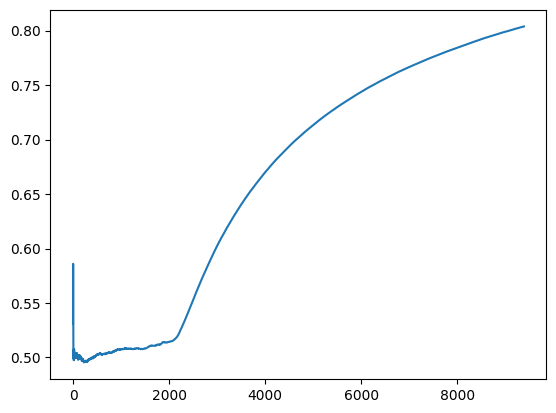

In [560]:
"🔒"
#
# Plot the training accuracy
#
hist.train_acc.plot.line();

In [561]:
"🔒"
#
# Save the entire model to disk
#
torch.save(model, 'mymodel.pt')

## Testing

The following code evaluates your model using `test_dataset`.

In [574]:
"🔒"
#
# Test your current model in memory
#
test_lib.test_saved_model(model)

Saved model has test accuracy = 85.38


In [575]:
"🔒"
#
# Test your saved model on disk
#
test_lib.test_saved_model()

Loading from mymodel.pt
Saved model has test accuracy = 85.96
